In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [9]:
def redistribute_force(F, L, alpha, F_thr, neighborhood='moore'):
    # Create a copy of the forces to store the new values
    F_new = np.copy(F)
    # List of active sites
    active_sites = []

    # Find active sites
    for i in range(L):
        for j in range(L):
            if F[i, j] >= F_thr:
                active_sites.append((i, j))

    # Redistribute forces from active sites
    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j]

        # Define the neighborhood for force redistribution
        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        else:  # von Neumann neighborhood
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

        # count no of neighbors 
        neighbors_count = 0    
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                neighbors_count += 1
        
        # Redistribute the force to the neighbors
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute)/neighbors_count

        # Set the force of the active site to zero
        F_new[i, j] = 1

    return F_new, active_sites

def simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore'):
    # Initialize the grid with random forces
    F = np.random.rand(L, L)
    initial_state = np.copy(F)

    active = True
    active_sites_count = 0
    active_sites_array = []
    while active:
        # Redistribute forces and get list of active sites
        F, active_sites = redistribute_force(F, L, alpha, F_thr, neighborhood)
        # If there are no active sites, break the loop
        active = len(active_sites) > 0
        active_sites_count += len(active_sites)

        if not active and n_additions > 0:
            # Locate site with the block closest to slip
            i, j = np.unravel_index(np.argmin(F_thr - F), F.shape)
            # Add the difference to all sites
            F += (F_thr - F[i, j])
            n_additions -= 1
            active_sites_array.append(active_sites_count)
            active_sites_count = 0
            active = True

    return initial_state, F, active_sites_array

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Initial state visualization
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    # Final state visualization
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    # Overall title and show
    plt.suptitle(title)
    plt.show()


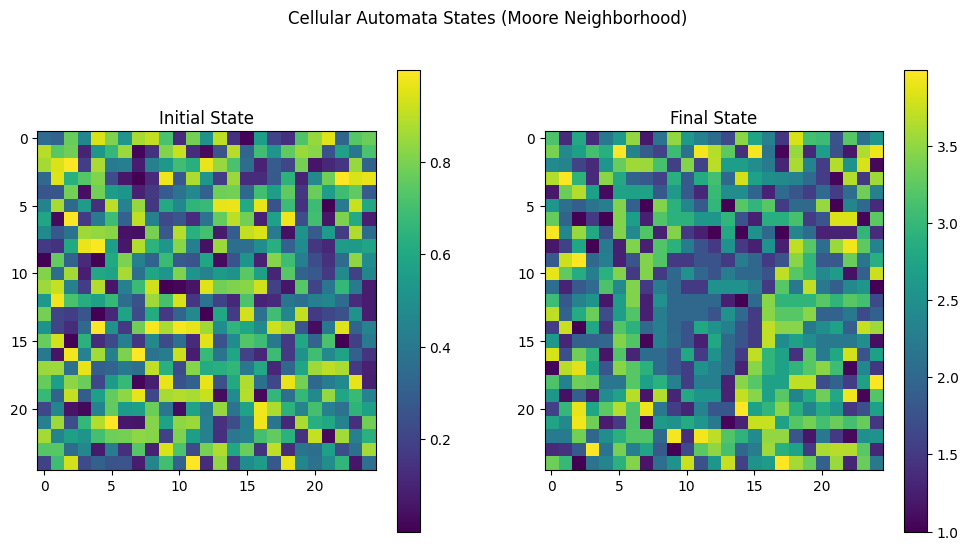

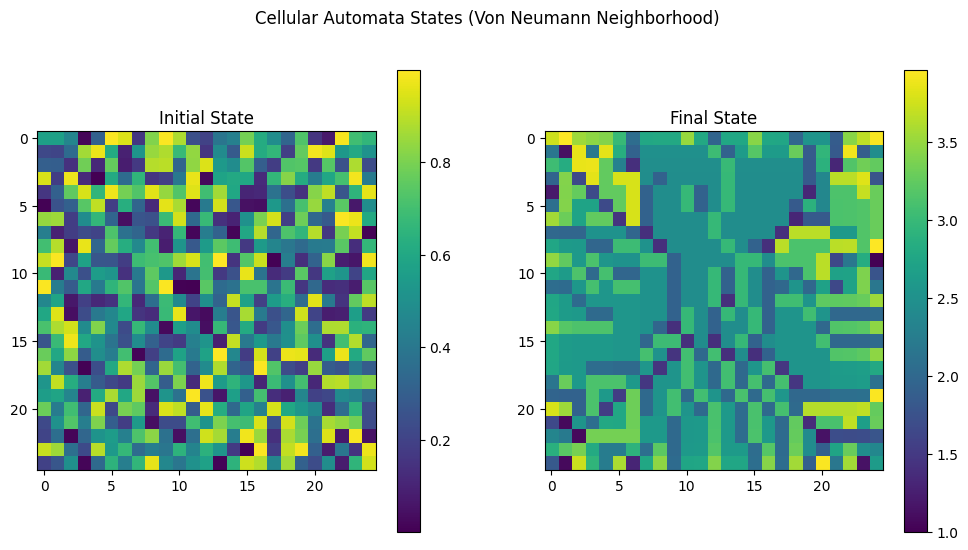

In [10]:
# Parameters
L = 25  # Size of the lattice
alpha = 0.5  # Coupling constant
F_thr = 4.0  # Threshold force
n_additions = 10000 # Number of additions of force to the system

# Run the simulation for Moore neighborhood
initial_state_moore, final_state_moore, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')

# Visualize the initial and final states for Moore neighborhood
visualize_states(initial_state_moore, final_state_moore, title='Cellular Automata States (Moore Neighborhood)')

# Run the simulation for Von Neumann neighborhood
initial_state_von, final_state_von, active_sites_von = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='von_neumann')

# Visualize the initial and final states for Von Neumann neighborhood
visualize_states(initial_state_von, final_state_von, title='Cellular Automata States (Von Neumann Neighborhood)')

In [45]:
# Run the simulation for Moore neighborhood multiple times
n_simulations = 30
active_sites_moore_array = []
for i in range(n_simulations):
    initial_state_moore, final_state_moore, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
    active_sites_moore_array.append(active_sites_moore)

In [46]:
# take all values of active sites and put them in one array
active_sites_all_moore = []
for i in range(n_simulations):
    active_sites_all_moore += active_sites_moore_array[i]
active_sites_all_moore = np.array(active_sites_all_moore)

# calculate the frequency
all_values_moore, all_counts_moore = np.unique(active_sites_all_moore, return_counts=True)
all_freq_moore = all_counts_moore / len(active_sites_all_moore)

# calculate the rank
all_rank_moore = np.arange(1, len(all_values_moore)+1)

In [49]:
# Define a negative power law function
def neg_power_law(x, a, b):
    return a * np.power(x, -b)

# Fit the negative power law to the data using curve_fit
params, _ = curve_fit(neg_power_law, all_values_moore, all_rank_moore)

# Generate fitted values using the parameters obtained from curve_fit
all_fitted = neg_power_law(all_values_moore, *params)

C:\Users\marit\AppData\Local\Temp\ipykernel_7288\45302110.py:3: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, -b)


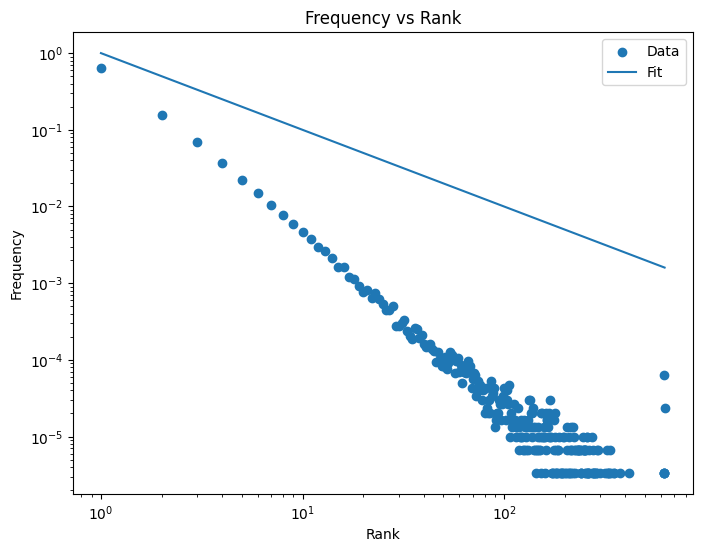

In [54]:
# Plot the frequency vs rank
plt.figure(figsize=(8, 6))
plt.scatter(all_values_moore, all_freq_moore, label='Data')
plt.plot(all_values_moore, all_fitted, label='Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Frequency vs Rank')
plt.legend()
plt.show()

C:\Users\marit\AppData\Local\Temp\ipykernel_7288\630107832.py:15: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, -b)


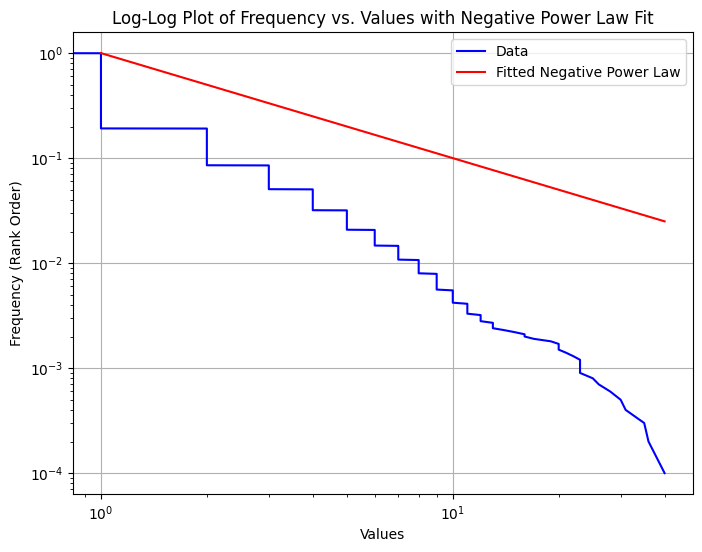

In [8]:
# Generate some data with a negative power law distribution
# For demonstration, let's create a sample array with a negative exponent

values = active_sites_moore  # 'a' is the exponent parameter

# Calculate the frequencies of each value
values_sorted = np.sort(values)
frequencies = np.arange(1, len(values_sorted) + 1) / len(values_sorted)

# Inverse the frequencies to get the ranks
ranks = frequencies[::-1]

# Define a negative power law function
def neg_power_law(x, a, b):
    return a * np.power(x, -b)

# Fit the negative power law to the data using curve_fit
params, _ = curve_fit(neg_power_law, values_sorted, ranks)

# Generate fitted values using the parameters obtained from curve_fit
fitted_ranks = neg_power_law(values_sorted, *params)

# Make a log-log plot of the data and the fitted curve
plt.figure(figsize=(8, 6))
plt.loglog(values_sorted, ranks, color='b', label='Data')
plt.loglog(values_sorted, fitted_ranks, 'r-', label='Fitted Negative Power Law')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency (Rank Order)')
plt.title('Log-Log Plot of Frequency vs. Values with Negative Power Law Fit')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()




In [ ]:
# plot the frequency
plt.figure(figsize=(8, 6))
plt.loglog(all_values_moore, all_freq_moore, 'b.', label='Data')
plt.loglog(all_values_moore, neg_power_law(all_values_moore, *params), 'r-', label='Fitted Negative Power Law')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of Frequency vs. Values with Negative Power Law Fit')
plt.legend()

Counter({1: 5940, 2: 1530, 3: 529, 4: 414, 5: 223, 8: 201, 6: 152, 10: 133, 9: 86, 11: 81, 7: 68, 17: 64, 16: 63, 28: 43, 12: 42, 33: 41, 36: 37, 85: 34, 63: 33, 13: 16, 14: 16, 62: 16, 57: 15, 46: 14, 18: 13, 61: 12, 15: 11, 40: 10, 67: 10, 25: 9, 20: 8, 64: 8, 27: 7, 24: 7, 26: 6, 47: 6, 53: 6, 21: 6, 22: 5, 60: 5, 79: 5, 19: 4, 58: 4, 81: 4, 51: 4, 84: 4, 34: 3, 44: 3, 48: 3, 92: 3, 82: 3, 23: 2, 29: 2, 43: 2, 32: 2, 54: 2, 59: 2, 30: 2, 88: 2, 87: 2, 93: 2, 127: 2, 0: 1, 31: 1, 38: 1, 49: 1, 52: 1, 37: 1, 56: 1, 71: 1, 75: 1, 66: 1, 65: 1, 69: 1, 80: 1, 96: 1, 89: 1, 118: 1, 116: 1, 113: 1})


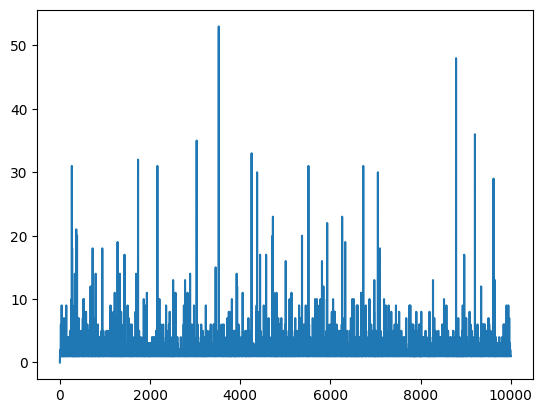

In [6]:
plt.plot(active_sites_moore, label='Moore')
from collections import Counter
occurrences_counter = Counter(active_sites_von)
print(occurrences_counter)

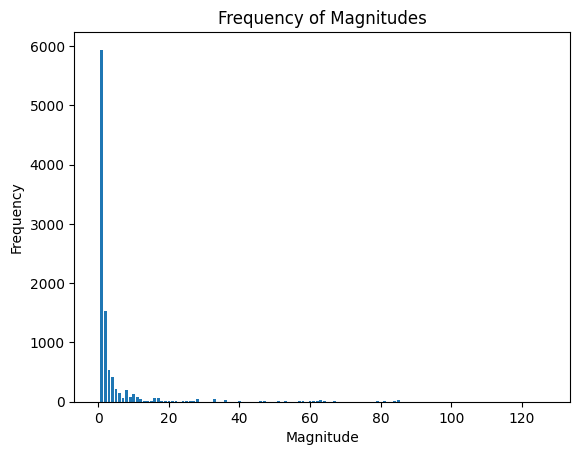

In [7]:
sorted_data = dict(sorted(occurrences_counter.items()))
magnitudes = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.bar(magnitudes, frequencies)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Frequency of Magnitudes')
plt.show()

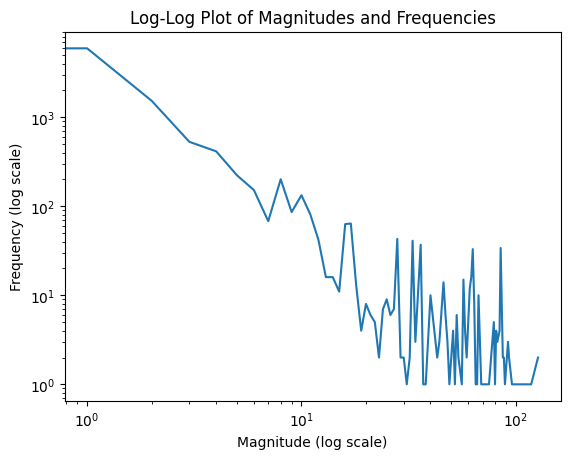

In [8]:
plt.loglog(magnitudes, frequencies)
plt.xlabel('Magnitude (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Log-Log Plot of Magnitudes and Frequencies')
plt.show()

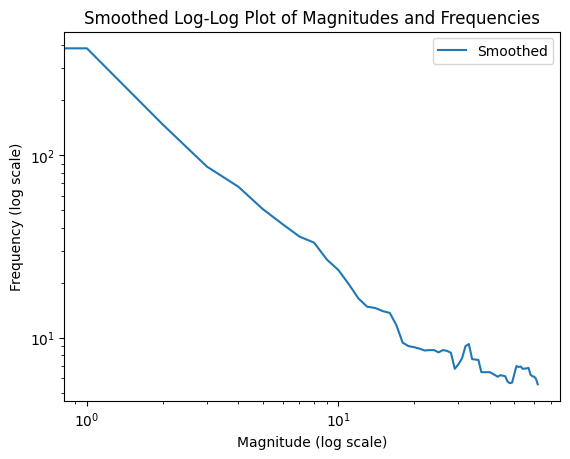

In [9]:
window_size = 25
smoothed_frequencies = np.convolve(frequencies, np.ones(window_size) / window_size, mode='valid')

# Plotting log-log
plt.loglog(magnitudes[:len(smoothed_frequencies)], smoothed_frequencies,label='Smoothed')
plt.xlabel('Magnitude (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Smoothed Log-Log Plot of Magnitudes and Frequencies')
plt.legend()
plt.show()